In [ ]:
import os
os.environ["keras_backend"] = "tensorflow"

In [1]:
!pip install tensorflow

  Running setup.py bdist_wheel for termcolor: started
  Running setup.py bdist_wheel for termcolor: finished with status 'done'
  Stored in directory: C:\Users\2346030y\AppData\Local\pip\Cache\wheels\7c\06\54\bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
  Running setup.py bdist_wheel for absl-py: started
  Running setup.py bdist_wheel for absl-py: finished with status 'done'
  Stored in directory: C:\Users\2346030y\AppData\Local\pip\Cache\wheels\59\23\a2\6a23b5ce3040b3dbb7ce5c21fa135ddae15c2966bf4a32836c
  Running setup.py bdist_wheel for gast: started
  Running setup.py bdist_wheel for gast: finished with status 'done'
  Stored in directory: C:\Users\2346030y\AppData\Local\pip\Cache\wheels\9a\1f\0e\3cde98113222b853e98fc0a8e9924480a3e25f1b4008cedb4f
Successfully built termcolor absl-py gast
  Found existing installation: numpy 1.12.1
    Uninstalling numpy-1.12.1:
      Successfully uninstalled numpy-1.12.1


You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
!pip install keras

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
import numpy as np
import pandas as pd
import tensorflow
import keras
from keras.layers import Convolution1D, Dense, MaxPooling1D, Flatten, Input
from keras.layers import Conv1D
from keras.layers.convolutional import AtrousConvolution1D
from keras.models import Sequential
import itertools
import matplotlib.pyplot as plt
import scipy
from scipy import signal
import timeit
%matplotlib inline



C:\local\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Load data

In [4]:
data=np.load('overnight_all_compressed.npz')
eval_data = data['arr_2']

Load train data from zip file and merge all files in to single array

In [5]:
#x = np.load('overnight_all_compressed_new.npz')
#print(x)
#x_t=[]
final_array=np.array([])

a = data['arr_0']
b = data['arr_1']

print(a.shape)
print(b.shape)


final_array=np.vstack([a,b])

print(final_array.shape)




(11044514, 4)
(4769867, 4)
(15814381, 4)


'for i in x:\n    \n    print(x[i].shape)\n    temp=x[i]\n    final_array = np.hstack()\n    final_array = np.concatenate((final_array,temp),axis=0)'

Divide data into X & Y sets for the train and validation data

In [6]:
X_train = final_array[:,1]
Y_train = final_array[:,2]

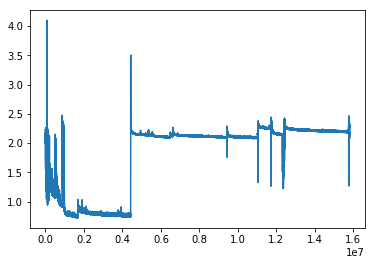

In [7]:
plt.plot(Y_train)

Differencing the target variable - abdominal stretch movement

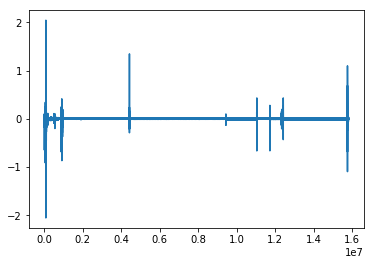

In [8]:
new_column = np.zeros([final_array.shape[0],1])
diff_array=np.hstack([final_array,new_column])
diff_array[1:,4]=np.diff(diff_array[:,2],axis=0)
plt.plot(diff_array[:,4])

manual median filter

In [9]:
def median_filter(x, n):    
    
    for i in range(n//2, len(x)-n-n//2):
        x[i+n//2,4] = np.median(x[i:i+n])
    return x

Applying median filter and time taken to calculate filter values

532.3354295111266


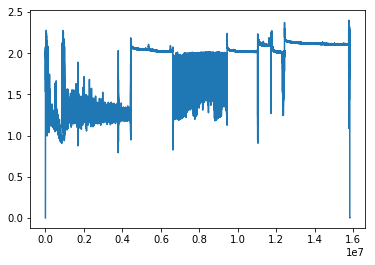

In [10]:
start=timeit.default_timer()
median_array=median_filter(diff_array,3)
stop=timeit.default_timer()
print(stop-start)
plt.plot(median_array[:,4])

CumSum of the above median filtered data

In [ ]:
median_array[:,4]=np.cumsum(median_array[:,4],axis=0)

plt.plot(median_array[:,4])

define X & Y train data

In [11]:
X_train=median_array[:,1]
Y_train=median_array[:,4]

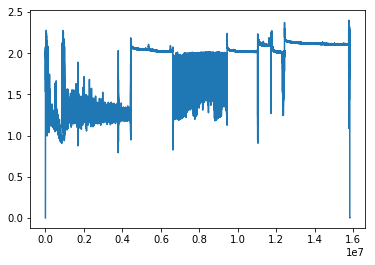

In [12]:
plt.plot(Y_train)

removing offset spikes using differencing followed by scipy median filter & cumsum

In [6]:
Y_train_diff=Y_train
Y_train_diff[1:]=np.diff(Y_train)
print(Y_train_diff.shape)
median_array_func=Y_train_diff
start=timeit.default_timer()
median_array_func=scipy.signal.medfilt(Y_train_diff,3)
print(median_array_func.shape)

stop=timeit.default_timer()
print(stop-start)
Y_train_final=np.cumsum(median_array_func)
print(Y_train_final.shape)



(15814381,)
(15814381,)
2.7448939
(15814381,)


In [7]:
Y_train=Y_train_final

Unseen Eval data divided in to X & Y for prediction & testing

In [8]:
time=eval_data[:1000000,0]
x_pred=eval_data[:1000000,5].reshape(1000000,1,1)
y_true=eval_data[:1000000,2]

model 1 with 1D Convolution layers and final dense/FC layer with filter of size 1,1,1

In [9]:
def Conv_test():
    model = Sequential()
    model.add(Convolution1D(32,1,border_mode='same',activation='relu'))
    model.add(Convolution1D(16,1,border_mode='same',activation='relu'))
    model.add(Convolution1D(2,1,border_mode='same',activation='relu'))
    model.add(Dense(1,activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
    return model

modified 1D CNN with dilation rate & final linear dense layer to linearise the output of the abdomen movement

In [10]:
def CausalConv_test():
    model = Sequential()    
    model.add(Conv1D(64,3,padding='same',activation='relu',dilation_rate=1, input_shape=(1000,1)))
    model.add(Conv1D(16,1,padding='same',dilation_rate=2,activation='relu'))
    model.add(Conv1D(2,1,padding='same',dilation_rate=4,activation='relu'))
    model.add(Conv1D(2,1,padding='same',dilation_rate=8,activation='relu'))

    model.add(Dense(4,activation='tanh'))
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [13]:
def CausalConv_test2():
    model = Sequential()    
    model.add(Conv1D(64,3,padding='same',activation='relu',dilation_rate=1, input_shape=(1000,1)))
    model.add(Conv1D(16,1,padding='same',dilation_rate=2,activation='relu'))
    model.add(Conv1D(2,1,padding='same',dilation_rate=4,activation='relu'))
    model.add(Conv1D(2,1,padding='same',dilation_rate=8,activation='relu'))

    model.add(Dense(4,activation='tanh'))
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model 2 with 1D Convolution layers and final dense/FC layer with filter of size 3, 1, 1

In [12]:
def Conv1D_test():
    model = Sequential()    
    model.add(Conv1D(64,3,padding='same',activation='relu', input_shape=(1000,1)))
    model.add(Conv1D(16,1,padding='same',activation='relu'))
    model.add(Conv1D(2,1,padding='same',activation='relu'))
    model.add(Dense(4,activation='tanh'))
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [13]:
def Dilated_Conv():
    model = Sequential()    
    model.add(AtrousConvolution1D(64,3,padding='same',activation='relu',atrous_rate=1, input_shape=(1000,1)))
    model.add(AtrousConvolution1D(16,1,padding='same',atrous_rate=2,activation='relu'))
    model.add(AtrousConvolution1D(2,1,padding='same',atrous_rate=4,activation='relu'))
    model.add(Dense(4,activation='tanh'))
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

#keras.layers.convolutional.AtrousConvolution1D(nb_filter, filter_length, init='glorot_uniform', activation=None, weights=None, border_mode='valid', subsample_length=1, atrous_rate=1, W_regularizer=None, b_regularizer=None, activity_regularizer=None, W_constraint=None, b_constraint=None, bias=True)

Split train data into train and validation using scikit method

In [14]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X_train,Y_train, test_size=0.33)

In [15]:
print(Y_train.shape)
print(X_train.shape)
print(median_array_func.shape)


(15814381,)
(15814381,)
(15814381,)


manually splitting train data  into train (70%) and validation (30% )

In [14]:
l= len(X_train)
Xtrain = X_train[:round(l*0.7)]
Xtest = X_train[round(l*0.7)+1:]
ytrain = Y_train[:round(l*0.7)]
ytest = Y_train[round(l*0.7)+1:]

Reshape the train & test into batches to train the model

In [15]:
window_size = 1000
leftover = len(Xtrain)%window_size

X_reshaped_train=(Xtrain[:-leftover]).reshape(-1,window_size,1)
print(X_reshaped_train.shape)

y_reshaped_train=(ytrain[:-leftover]).reshape(-1,window_size,1)

leftover_test = len(Xtest)%window_size

X_reshaped_test=(Xtest[:-leftover_test]).reshape(-1,window_size,1)
y_reshaped_test=(ytest[:-leftover_test]).reshape(-1,window_size,1)



(11070, 1000, 1)


In [16]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)


# Xtrain=(Xtrain).reshape(len(Xtrain),1,1)

# ytrain=ytrain.reshape(len(ytrain),1,1)

# Xtest=Xtest.reshape(len(Xtest),1,1)

# ytest=ytest.reshape(len(ytest),1,1)

validationData=(Xtest,ytest)
'''
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)'''
print(Xtrain.shape)

model=CausalConv_test2()
history = model.fit(X_reshaped_train,y_reshaped_train,
                    validation_data=(X_reshaped_test, y_reshaped_test),
                    epochs=10,batch_size=50,
                    callbacks=[early_stopping])

(11070067,)
Train on 11070 samples, validate on 4744 samples
Epoch 1/10
11070/11070 [==============================] - 541s 49ms/step - loss: 1.4425 - val_loss: 0.8269
Epoch 2/10
11070/11070 [==============================] - 524s 47ms/step - loss: 0.1649 - val_loss: 0.2159
Epoch 3/10
11070/11070 [==============================] - 524s 47ms/step - loss: 0.1323 - val_loss: 0.2221
Epoch 4/10
11070/11070 [==============================] - 528s 48ms/step - loss: 0.1324 - val_loss: 0.2234


dict_keys(['val_loss', 'loss'])


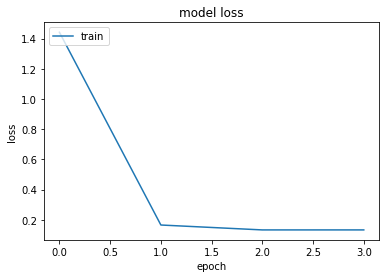

In [17]:
print(history.history.keys())
#y_pred=model.predict(x_pred)
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
x_reshaped_pred= x_pred.reshape(-1,window_size,1)

NameError: name 'x_pred' is not defined

In [19]:
print(x.shape)

NameError: name 'x' is not defined

In [20]:
y_pred=model.predict(X_reshaped_train)
y_pred_unravel=y_pred.reshape(-1,1)
print(y_pred_unravel.shape)

(11070000, 1)


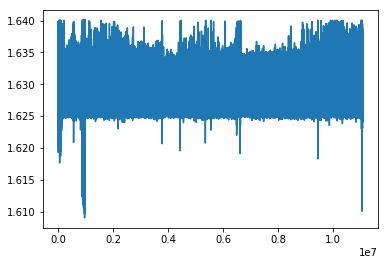

In [21]:
plt.plot(y_pred_unravel)

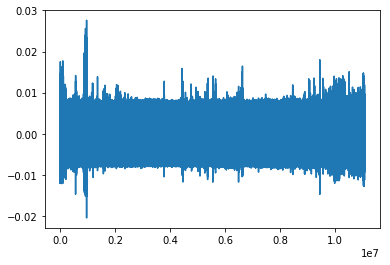

In [25]:
plt.plot(np.diff(y_pred_unravel,axis=0))

(11070, 1000, 1)
[[1.6320454]
 [1.6329803]
 [1.6337042]
 ...
 [1.6331515]
 [1.6330096]
 [1.6255093]]


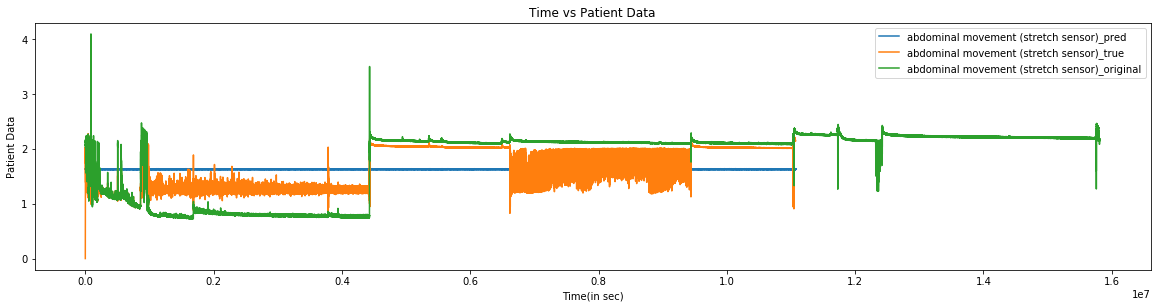

In [26]:
y_pred=model.predict(X_reshaped_train)
y_pred.reshape(-1,1)
print(y_pred.shape)
y_pred= y_pred.reshape(-1,1)
print(y_pred)
fig = plt.figure(figsize=(20,10))
#for ix,items in zip([1,2],x):
ax = fig.add_subplot(2,1,1)
ax.set_title('Time vs Patient Data')
ax.set_xlabel('Time(in sec)')
ax.set_ylabel('Patient Data')
ax.plot(y_pred,label='abdominal movement (stretch sensor)_pred')
ax.plot(y_reshaped_train.reshape(-1,1),label='abdominal movement (stretch sensor)_true')
ax.plot(final_array[:,2],label='abdominal movement (stretch sensor)_original')




ax.legend()


In [ ]:


y_pred=model.predict(x_reshaped_pred)
print(y_pred.shape)
y_pred= y_pred.reshape(-1,1)
fig = plt.figure(figsize=(20,10))
#for ix,items in zip([1,2],x):
ax = fig.add_subplot(2,1,1)
ax.set_title('Time vs Patient Data')
ax.set_xlabel('Time(in sec)')
ax.set_ylabel('Patient Data')
ax.plot(time,y_pred,label='abdominal movement (stretch sensor)_pred')
ax.plot(time,y_true,label='abdominal movement (stretch sensor)_true')



ax.legend()


In [ ]:
# note: try differencing, median filtering and cumsum to remove offset spikes